In [57]:
import pandas as pd
import numpy as np
import torch
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import wandb  # будем использовать для логирования
import re
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from torch.nn.utils.rnn import pad_sequence
from nltk.corpus import stopwords
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F

wandb.login()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
!wandb login cc603ae0565bbbfce5cc5b068a9bddabb8950920

wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [29]:
data_train = pd.read_csv('data/train.csv', sep=',')
data_test = pd.read_csv('data/test.csv', sep=',')

# Выделяем целевые переменные
labels_train = data_train['label']
labels_test = data_test['label']

# Смотрим на размер данных
len(data_train), len(data_test)
# Output:
# (120000, 7600)


(120000, 7600)

In [30]:
data_train['text'][:5]

0    Wall St. Bears Claw Back Into the Black (Reute...
1    Carlyle Looks Toward Commercial Aerospace (Reu...
2    Oil and Economy Cloud Stocks' Outlook (Reuters...
3    Iraq Halts Oil Exports from Main Southern Pipe...
4    Oil prices soar to all-time record, posing new...
Name: text, dtype: object

In [38]:
def tokenize(text):
    reg = re.compile(r'\w+')
    return reg.findall(text)
    
# Применяем функцию токенизации текстов к тренировочной и тестовой выборкам    
data_tok_train = [tokenize(t.lower()) for t in data_train['text']]
data_tok_test = [tokenize(t.lower()) for t in data_test['text']]

In [40]:
stop_words = stopwords.words('english')

def remove_stopwords(tokenized_texts):
    clear_texts = []
    for words in tokenized_texts:
        clear_texts.append([word for word in words if word not in stop_words])

    return clear_texts


In [41]:
data_tok_train = remove_stopwords(data_tok_train)
data_tok_test = remove_stopwords(data_tok_test)


In [42]:
def lemmatize_text(tokenized_texts):
    lemmatized_data = []
    lemmatizer = WordNetLemmatizer()
    for words in tqdm(tokenized_texts):
        lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
        lemmatized_data.append(lemmatized_words)
    return lemmatized_data
    
    
lemmatized_train = lemmatize_text(data_tok_train)
lemmatized_test = lemmatize_text(data_tok_test)


  0%|          | 0/120000 [00:00<?, ?it/s]

  0%|          | 0/7600 [00:00<?, ?it/s]

In [45]:
w2v_model = Word2Vec(
    lemmatized_train,
    vector_size=100,
    min_count=4,
    window=5
).wv


In [ ]:
w2v_model.get_vector('word')

array([-0.35229364, -0.28613487,  0.84874773, -0.88647336,  0.667387  ,
       -0.14061968, -0.01737839,  1.4909592 , -0.00771039,  0.24994071,
       -1.8264297 , -0.15398373, -0.4901986 , -0.05590612, -0.7811263 ,
       -0.0653145 , -0.14628246,  0.27856007,  1.6799984 , -0.4447753 ,
        0.60498357,  0.22106847,  0.64900684,  0.486832  , -0.63211846,
        1.1653243 , -0.33075592, -0.01126555,  0.89076424,  1.9020722 ,
       -0.17842266,  0.20437464,  0.5035975 , -0.3293477 ,  0.44938287,
       -0.2260476 ,  0.0100739 ,  0.99903256, -0.27758387,  0.01884967,
        0.45393792,  0.35218117,  0.07084449, -0.7445908 ,  0.75876284,
       -0.41674593,  0.23770867,  0.5613349 , -0.08249725,  0.49912533,
        0.09932999,  1.0813301 ,  0.39050052,  0.47824636, -0.92539513,
       -0.05390639,  0.17725924,  0.15128887, -0.21435738,  0.5724732 ,
       -1.4903504 , -1.2104806 ,  1.8208798 ,  0.84873897, -0.19134171,
       -0.93908894,  0.5832773 ,  0.0710884 , -0.5020134 ,  0.74

In [47]:
def encode_dataset(dataset):
    encoded = []
    
    for words in dataset:
        vectors = [w2v_model.get_vector(word) for word in words if word in w2v_model]
        encoded.append(torch.from_numpy(np.array(vectors)))

    return encoded


In [48]:
train_embeddings = encode_dataset(lemmatized_train)
test_embeddings = encode_dataset(lemmatized_test)

Text(0, 0.5, 'Count')

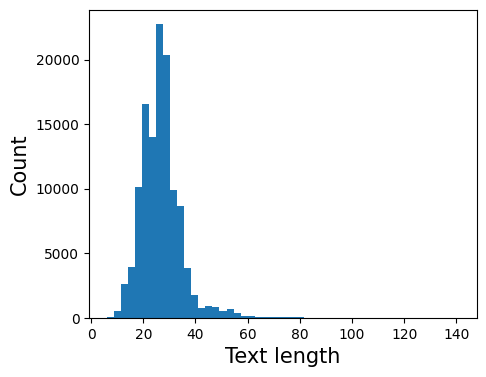

In [50]:
text_lens = [len(x) for x in train_embeddings]

plt.figure(figsize=(5, 4))
plt.hist(text_lens, bins=50);
plt.xlabel('Text length', size=15)
plt.ylabel('Count', size=15)


In [ ]:
train_dataset = list(zip(train_embeddings, labels_train))
test_dataset = list(zip(test_embeddings, labels_test))

In [54]:
def collate_fn(batch):
    x, labels = zip(*batch)
    return pad_sequence(x).permute(1, 0, 2), torch.tensor(labels)


In [56]:
w2v_train_loader = DataLoader(train_dataset, collate_fn=collate_fn, shuffle=True, batch_size=32)
w2v_test_loader = DataLoader(test_dataset, collate_fn=collate_fn, shuffle=False, batch_size=8)

batch = next(iter(w2v_test_loader))
batch


(tensor([[[-3.3838e-01, -9.9892e-01, -8.7270e-01,  ...,  1.2466e+00,
           -3.3864e-02,  2.7508e+00],
          [ 2.6088e+00,  4.7691e-02, -5.0086e-01,  ...,  1.1848e+00,
            1.2159e+00, -3.6392e+00],
          [-1.6324e+00, -3.2776e-01, -1.3693e+00,  ...,  5.7285e-02,
            1.1416e+00, -9.6249e-01],
          ...,
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]],
 
         [[-5.1029e-01,  1.4889e+00,  7.0259e-01,  ..., -2.4097e+00,
           -3.0551e+00,  6.6585e-01],
          [-4.1358e-02,  2.8291e+00, -5.9502e-01,  ..., -2.7954e+00,
           -1.4224e+00, -9.7065e-01],
          [-7.4231e-01,  1.5922e+00, -1.3230e+00,  ...,  1.9883e-01,
           -2.9116e-01,  9.4280e-01],
          ...,
    

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, hid_dim=100, n_classes=4):
        super().__init__()
        
        # не меняем число каналов
        self.conv1 = nn.Conv1d(hid_dim, hid_dim, kernel_size=3, stride=1, padding=0)
        self.conv2 = nn.Conv1d(hid_dim, hid_dim, kernel_size=3, stride=1, padding=0)

        self.fc = nn.Linear(hid_dim, n_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        # x: [batch_size, seq_len, dim]
        # меняем местами размерности, так как число каналов (dim) должно стоять на втором месте
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        
        x = F.max_pool1d(x, x.size(-1)).squeeze(dim=-1)
        
        x = self.fc(x)
        return x

In [ ]:
def train(model, dataloader, optimizer):
    """
    Обучает модель (model) на всем наборе данных (dataloader).
    """
    
    # не забываем переводить в train режим
    model.train()
    criterion = nn.CrossEntropyLoss()
    
    # сэмплируем из dataloader наши объекты и целевые переменные
    for i, (tokens, labels) in enumerate(dataloader):
		    # перемещаем на device
        tokens = tokens.to(device)
        labels = labels.to(device)
        
        # прогоняем через модель
        logits = model(tokens)
        # считаем ошибку
        loss = criterion(logits, labels)
        
        # делаем шаг оптимизации
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # логируем значения ошибки и точности
        wandb.log({
            "train_loss": loss.item(),
            "train_accuracy": (logits.argmax(-1) == labels).float().mean().item()
        })

In [60]:
@torch.inference_mode()
def evaluate(model, dataloader):
    """
    Тестирует модель (model) на всем наборе данных (dataloader).
    """
    
    # не забываем переводить в eval режим
    model.eval()
    criterion = nn.CrossEntropyLoss()

    correct = []
    losses = []
    for i, (tokens, labels) in enumerate(dataloader):
        tokens = tokens.to(device)
        labels = labels.to(device)

        logits = model(tokens)
        loss = criterion(logits, labels)

        correct.extend((logits.argmax(-1) == labels).float().cpu())
        losses.append(loss.item())

    mean_loss = np.mean(losses)
    accuracy = np.mean(correct)
    
    # логируем тестовые значения ошибки и точности
    wandb.log({
        "test_loss": mean_loss,
        "test_accuracy": accuracy
    })

    return accuracy, mean_loss

In [61]:
# инициализируем модель и переводим на GPU, если есть
model = SimpleCNN().to(device)

# используем Adam для обучения
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)

In [62]:
wandb.init(project="nlp_lesson2", name="simple_cnn")

# учим в течение 5 эпох
for epoch in range(5):
    train(model, w2v_train_loader, optimizer)
    test_accuracy, test_loss = evaluate(model, w2v_test_loader)

wandb.finish()

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


test_accuracy,▁▄▄██
test_loss,█▅▄▂▁
train_accuracy,▅▆▆▄▃▆▆▇▂▁█▆▃▅▇▅▂█▄▁▇▆█▅▃▄▄▄▃▇▅▆▅▅▅▆▂▆▇▂
train_loss,█▆▄▃▅▂▄▄▃▄▄▃▃▄▃▄▃▅▃▅▁▁▄▃▂▅▂▆▃▂▂▃▃▂▅▅▃▃▂▂
test_accuracy,0.89934
test_loss,0.29368
train_accuracy,0.9375
train_loss,0.22889


In [63]:
print('SimpleCNN')
print('Test accuracy:', test_accuracy)
print('Test loss:', test_loss)

# Output:
# SimpleCNN
# Test accuracy: 0.895
# Test loss: 0.2985722840430313


SimpleCNN
Test accuracy: 0.8993421
Test loss: 0.29367655711444585
